Import Library

In [1]:
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from matplotlib.colors import Normalize
from IPython.display import Audio
import tensorflow as tf
from tensorflow import keras

Simpan path dataset

In [2]:
RAVDESS = "/Dataset/RAVDESS"

Load Dataset

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []
duration = []

emotion_dic = {
    '02': 'calm',
    '05': 'angry',
    '07': 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files:
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(os.path.join(RAVDESS, directory, audio_file))
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            duration.append(round(librosa.get_duration(path=path_list[-1]), 3)) 
         
df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(duration, columns=['duration']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

df.head()

,path,sex,duration,emotion
0,/Dataset/RAVDESS\Actor_01\03-01-02-01-01-01-01...,male,3.537,calm
1,/Dataset/RAVDESS\Actor_01\03-01-02-01-01-02-01...,male,3.604,calm
2,/Dataset/RAVDESS\Actor_01\03-01-02-01-02-01-01...,male,3.503,calm
3,/Dataset/RAVDESS\Actor_01\03-01-02-01-02-02-01...,male,3.470,calm
4,/Dataset/RAVDESS\Actor_01\03-01-02-02-01-01-01...,male,3.704,calm


In [4]:
print(f'Total # of sample in whole dataset: {len(df)}')

Total # of sample in whole dataset: 576


In [5]:
df['emotion'].value_counts()

calm       192
angry      192
disgust    192
Name: emotion, dtype: int64

In [6]:
df['sex'].value_counts()

male      288
female    288
Name: sex, dtype: int64

Membuat dataframe

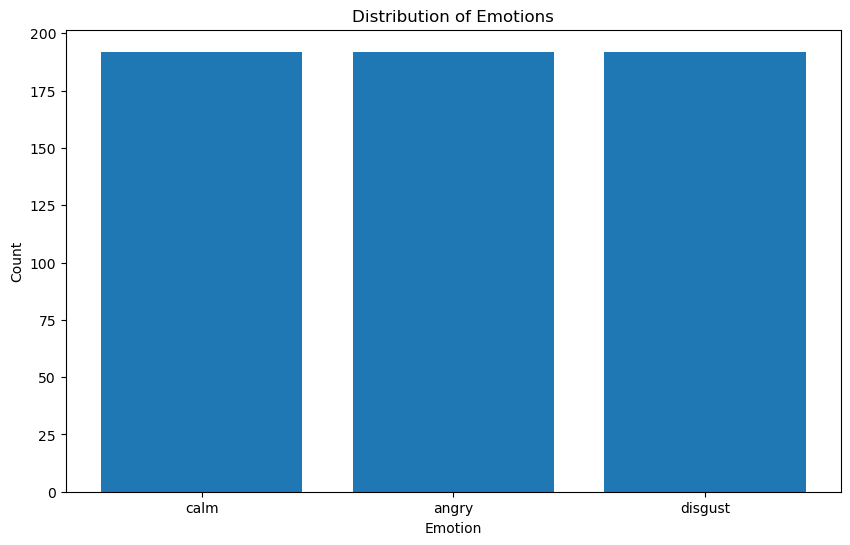

In [7]:
label_counts = df['emotion'].value_counts()

# Buat bar plot
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [8]:
def create_waveplot(data, sr, e):
    # Create waveplot
    plt.figure(figsize=(14, 5))
    plt.plot(data)
    plt.title('Waveplot - Emotion: {}'.format(e))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [10]:
emotion='neutral'
path = np.array(df.path[df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

IndexError: index 1 is out of bounds for axis 0 with size 0

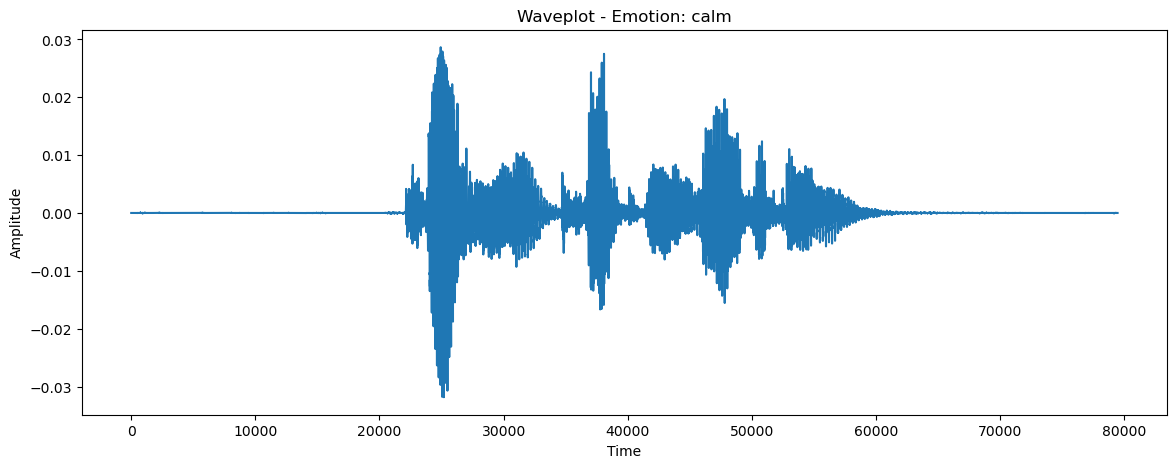

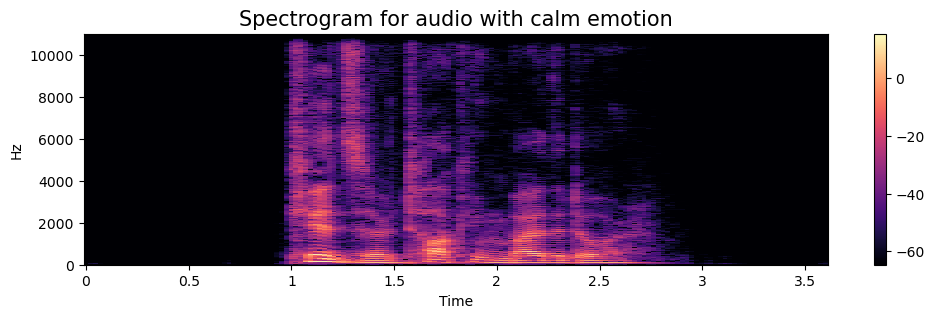

In [11]:
emotion='calm'
path = np.array(df.path[df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [12]:
emotion='happy'
path = np.array(df.path[df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

IndexError: index 1 is out of bounds for axis 0 with size 0

In [13]:
emotion='sad'
path = np.array(df.path[df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

IndexError: index 1 is out of bounds for axis 0 with size 0

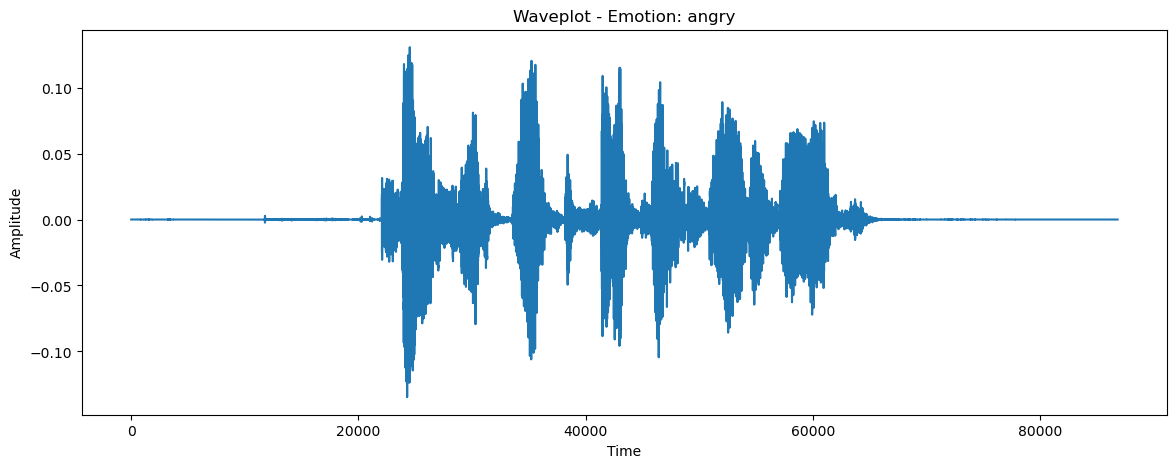

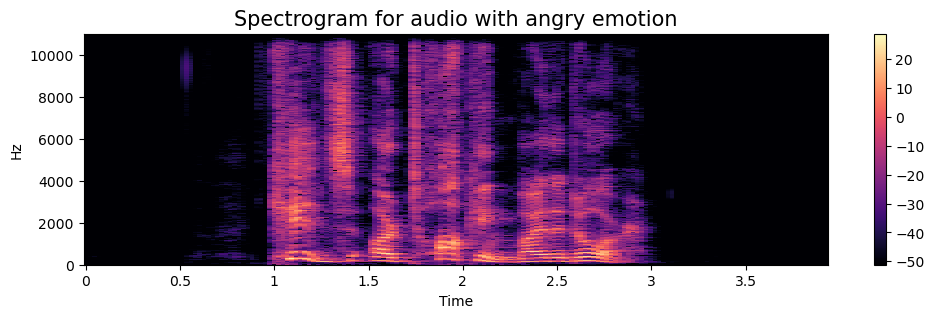

In [14]:
emotion='angry'
path = np.array(df.path[df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [15]:
emotion='fear'
path = np.array(df.path[df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

IndexError: index 1 is out of bounds for axis 0 with size 0

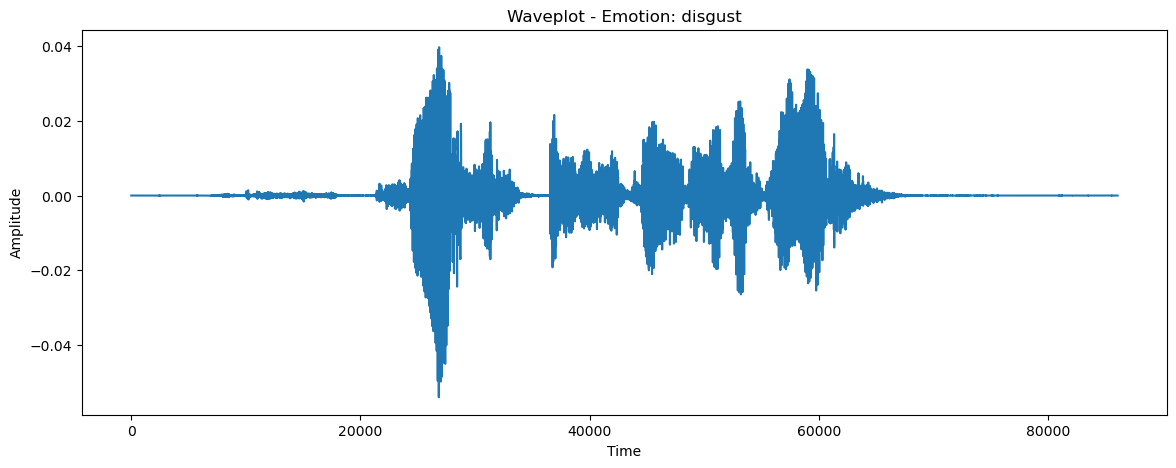

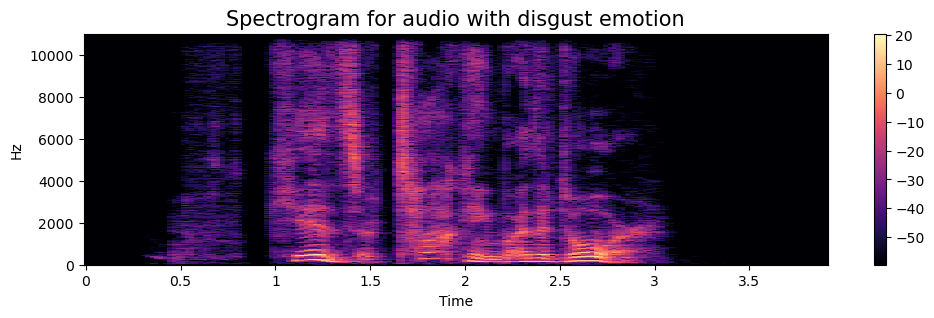

In [16]:
emotion='disgust'
path = np.array(df.path[df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [17]:
emotion='surprised'
path = np.array(df.path[df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

IndexError: index 1 is out of bounds for axis 0 with size 0

Ekstraksi Fitur

In [18]:
%%time

# Create a variable where to store the mfccs data
mfccs = []

for file in df.path:
    # load audio file:
    y, sr = librosa.load(file, sr=16000)
    
    # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30)
    mfccs.append(mfcc)

CPU times: total: 1min
Wall time: 11.4 s


In [19]:
def resize_array(array):
    new_matrix = np.zeros((30,150))   # Initialize the new matrix shape with an array 30X150 of zeros
    for i in range(30):               # Iterate rows
        for j in range(150):          # Iterate columns
            try:                                 # the mfccs of a sample will replace the matrix of zeros, then cutting the array up to 150
                new_matrix[i][j] = array[i][j]
            except IndexError:                   # if mfccs of a sample is shorter than 150, then keep looping to extend lenght to 150 with 0s
                pass
    return new_matrix

# Create a variable to store the new resized mfccs and apply function for all the extracted mfccs
resized_mfccs = []

for mfcc in mfccs:
    resized_mfccs.append(resize_array(mfcc))

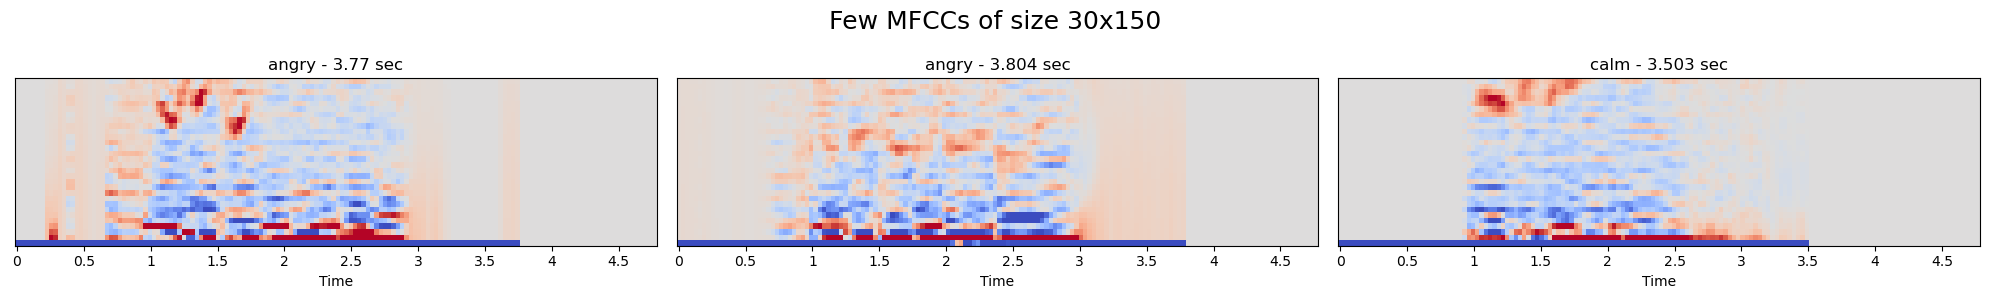

In [20]:
# Create sublots
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(20,3))

# Select 4 random MFCCs
for i in range(3):
    index = random.randint(0, len(resized_mfccs))
    
    # Plot MFCCs
    librosa.display.specshow(resized_mfccs[index], sr=sr, x_axis="time", ax=axs[i], norm=Normalize(vmin=-50, vmax=50))
    axs[i].set_title(str(df.emotion[index]) + ' - ' + str(df.duration[index]) + ' sec')

plt.suptitle('Few MFCCs of size 30x150', size=18)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# Select target
df['emotion'].replace({'calm':0,'angry':1,'disgust':2}, inplace=True)
from keras.utils import to_categorical

y = to_categorical(df.emotion.values, num_classes=3)
# Features
X = resized_mfccs.copy()

# Create train, validation and test set
X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=0)

# Convert data to numpy arrays
X_train = np.array([i for i in X_train])
X_test = np.array([i for i in X_test])

# Plot size of data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(403, 30, 150)
(173, 30, 150)
(403, 3)
(173, 3)


In [22]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [23]:
# Get mean and standard deviation from the training set
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# Apply data scaling
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [24]:
print(f"X_train has a dimension of {X_train.shape} before the manipulation.")

X_train = X_train[..., None]
X_test = X_test[..., None]

print(f"X_train has a dimension of {X_train.shape} after the manipulation.")

X_train has a dimension of (403, 30, 150) before the manipulation.
X_train has a dimension of (403, 30, 150, 1) after the manipulation.


In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D


model = tf.keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu", input_shape=(30, 150, 1)),
    layers.MaxPool2D(pool_size=2),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=2, strides=(2, 2), activation="relu"),
    layers.MaxPool2D(pool_size=2),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 74, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 37, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 37, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 18, 32)         8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 9, 32)         0         
 2D)                                                             
                                                        

In [26]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=50,
) 

Epoch 1/50
13/13 [==============================] - 1s 31ms/step - loss: 1.4197 - accuracy: 0.3648 - val_loss: 1.0534 - val_accuracy: 0.5029
Epoch 2/50
13/13 [==============================] - 0s 14ms/step - loss: 1.1104 - accuracy: 0.5037 - val_loss: 1.0095 - val_accuracy: 0.5665
Epoch 3/50
13/13 [==============================] - 0s 13ms/step - loss: 0.9425 - accuracy: 0.5658 - val_loss: 0.9767 - val_accuracy: 0.5954
Epoch 4/50
13/13 [==============================] - 0s 14ms/step - loss: 0.9315 - accuracy: 0.6030 - val_loss: 0.9807 - val_accuracy: 0.4740
Epoch 5/50
13/13 [==============================] - 0s 14ms/step - loss: 0.7610 - accuracy: 0.6427 - val_loss: 0.9693 - val_accuracy: 0.4971
Epoch 6/50
13/13 [==============================] - 0s 14ms/step - loss: 0.7262 - accuracy: 0.6849 - val_loss: 0.9723 - val_accuracy: 0.4682
Epoch 7/50
13/13 [==============================] - 0s 14ms/step - loss: 0.6766 - accuracy: 0.7097 - val_loss: 0.9589 - val_accuracy: 0.5087
Epoch 8/50
13

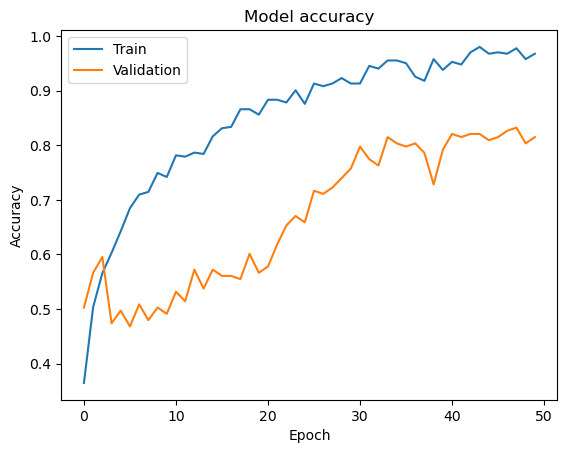

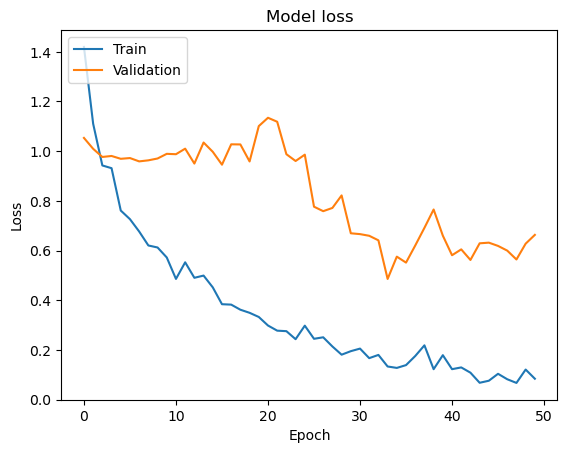

In [27]:
# plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
model.save("model.h5")

In [37]:
import tensorflow as tf
model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflmodel = converter.convert()
file = open( 'yourmodel.tflite' , 'wb' ) 
file.write( tflmodel )

INFO:tensorflow:Assets written to: C:\Users\WIGAAU~1\AppData\Local\Temp\tmpwpts3gnn\assets


INFO:tensorflow:Assets written to: C:\Users\WIGAAU~1\AppData\Local\Temp\tmpwpts3gnn\assets


TypeError: EndVector() takes 1 positional argument but 2 were given

In [55]:
import numpy as np

# Pilih data test secara acak
#index = np.random.randint(0, len(X_test))
sample = X_test[index]
sample = np.expand_dims(sample, axis=0)

# Lakukan prediksi
prediction = model.predict(sample)

# Ambil label dengan nilai tertinggi sebagai output
predicted_label = np.argmax(prediction)

# Cetak output label
print("Predicted label:", predicted_label)

1/1 [==============================] - 0s 13ms/step
Predicted label: 1


NameError: name 'librosa' is not defined